# Import

In [1]:
import sys
import os
sys.path.append("../src")

from utils import *
from mitigation_fct import *
from distance import *
from Gems_Wasserstein import *
from sampling import *

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from tqdm import tqdm
from scipy import stats

import torch
import torch.nn as nn
import schedulefree

import ot

In [2]:
dic_file = {
    'ASC_INC' : {
        'path' : '../Data/ASCIncome_2023.csv',
        'model' : Network(8, activation_bool = True, n_nodes=256, n_loop = 2)
    },
    'ASC_TRA' : {
        'path' : '../Data/ACSTravelTime_2023.csv',
        'model' : Network_old(19, activation_bool = True, n_nodes=512, n_loop = 2)
    },
    'ASC_MOB' : {
        'path' : '../Data/ACSMobility_2023.csv',
        'model' : Network(19, activation_bool = True, n_nodes=256, n_loop = 2)
    },
    'ASC_EMP' : {
        'path' : '../Data/ACSEmploymentFiltered_2023.csv',
        'model' : Network(15, activation_bool = True, n_nodes=256, n_loop = 2)
    },
    'ASC_PUC' : {
        'path' : '../Data/ACSPublicCoverage_2023.csv',
        'model' : Network(18, activation_bool = True, n_nodes=256, n_loop = 2)
    },
    'BAF' : {
        'path' : '../Data/BAF/Base_mod.csv',
        'model' : Network_old(42, activation_bool = True, n_nodes=1024, n_loop = 2),
    },
    'ADULT' : {
        'path' : '../Data/BAF/Base_mod.csv',
        'model' : Network(34, activation_bool = True, n_nodes=256, n_loop = 2),
    }
}

In [3]:
dic_sample_size_folder = {
    'ADULT'   : [500, 1000],
    'ASC_EMP' : [2000, 4000],
    'ASC_INC' : [2000, 4000],
    'ASC_MOB' : [2000, 4000],
    'ASC_PUC' : [2000, 4000],
    'ASC_TRA' : [2000, 4000],
    'BAF'     : [2000, 4000],
}
folders_name = dic_sample_size_folder.keys()

In [ ]:
result_path = '../Result/'
S_index, Y_index = -2, -1
dic_arr_results = {}
for folder in folders_name:
    if folder[-4:] != '.csv':
        files = os.listdir(result_path + folder)
        if files != []:
            dic_arr_results[folder] = {}
        for file in files:
            if file[-4:] == '.npy':
                try:
                    arr = np.load(file = result_path + folder + '/' + file)
                    dic_arr_results[folder][file[:-4]] = arr
                except:
                    'yes'

# Function

In [5]:
def return_KL_W_result_unbaisedness(unb_fct,
                                    arr_original,
                                    arr_DIs,
                                    verbose = True,
                                    method_is_gems = False,
                                    W_on_X = False,
                                    ):
    
    if method_is_gems:
        n = len(arr_original)
        if W_on_X:
            M = ot.dist(x1 = arr_original[:,:-2], 
                        x2 = arr_original[:,:-2], 
                        p=2, 
                        metric = 'euclidean')
        else:
            M = ot.dist(x1 = arr_original, 
                        x2 = arr_original, 
                        p=2, 
                        metric = 'euclidean')

 
    arr_KL_A, arr_W_A = np.zeros(len(arr_DIs)), np.zeros(len(arr_DIs))

    for i, DI in enumerate(arr_DIs):
        if verbose:
            print(DI)
        unb_arr = unb_fct(DI)
        if verbose:
            print('unbaisedness done')

        if method_is_gems:
            lambdas = unb_arr[:,-1]

            KL_unb = KL_lambda_fct(lambdas)

            if verbose:
                print(f'KL_A done : {KL_unb}')

            W_unb  = ot.emd2(np.ones(n)/n, 
                            lambdas, 
                            M, 
                            numItermax=1e7)
            
        else:
            KL_unb = KL_arr(arr_P = arr_original,
                            arr_Q = unb_arr)
            if verbose:
                print(f'KL_A done : {KL_unb}')
            if W_on_X:
                W_unb = Wasserstein(arr_original[:,:-2], 
                                    unb_arr[:,:-2],
                                    numItermax = 1e7)
            else:
                W_unb = Wasserstein(arr_original, 
                                    unb_arr,
                                    numItermax = 1e7)
        if verbose:
            print(f'W_A done : {W_unb}')
        arr_KL_A[i], arr_W_A[i] = KL_unb, W_unb
    return arr_KL_A, arr_W_A


In [ ]:
def return_KL_W_result_unbaisedness_all_methods(folder,
                                                S_index = S_index, 
                                                Y_index = Y_index,
                                                DI_end = 0.8,
                                                verbose = False,
                                                W_on_X = False,
                                                CONSTR_REGU = 0.1
                                                ):
    arr_original = dic_arr_results[folder]['original']
    prob_threshold = torch.tensor(dic_arr_results[folder]['threshold'])

    DI_start = DI_fct(arr_original, 
                S_index = S_index, 
                Y_index = Y_index,
                )
    
    mitigation_fct_S = lambda DI : find_sampling_wasserstein_DI(arr = arr_original,
                                                          threshold = DI,
                                                          S_index = S_index,
                                                          Y_index = Y_index,
                                                          )[0]
    mitigation_fct_R = lambda DI : find_translation_DI(arr = arr_original,
                                                   S_index = S_index,
                                                   Y_index = Y_index,
                                                   threshold = DI,
                                                   bool_return_all = True,
                                                   verbose = False,
                                                   speed = 1,
                                                   )[0]
    mitigation_fct_Ge = lambda DI, delta_type : Gems_fair_mitigation_arr(arr=arr_original, 
                                                            S_column_index = S_index,
                                                            Pred_column_index = Y_index,
                                                            DI_target = DI,
                                                            delta_type = delta_type)

    def mitigation_fct_Grad(DI, 
                            folder = folder,
                            look_alike = False,
                            prob_threshold = prob_threshold,
                            delta_type = 'mean',
                            ):

        model = dic_file[folder]['model']
        #the eval is very important as we use batchnorm layer ! 
        model.eval()
        net_path = '../Result/' + folder + '/net_state_dic.pt'
        model.load_state_dict(torch.load(net_path, weights_only=True))
        stresser = Stresser(X = arr_original[:,:-2].astype(float), 
                            S = arr_original[:,S_index],
                            )

        stresser.W.DI_miti_grad(model,
                                threshold = DI,
                                prob_threshold = prob_threshold,
                                threshold_augm_constr = 0.005,
                                stop_condition_threshold = 0.05,
                                threshold_lr_cdt = 0.1,
                                iteration_threshold = 300,
                                look_alike = look_alike,
                                verbose = False,
                                CONSTR_REGU = 0.1, 
                                lr = 0.1,
                                delta_type = delta_type,
                                )
        new_inputs = stresser.X + stresser.W.t
        pred = (model(torch.from_numpy(new_inputs).float()) > prob_threshold)*1.

        new_arr = np.concatenate([new_inputs, stresser.S.reshape(len(stresser.X), -1), pred], axis = 1)
        return new_arr
    
    dic_method_fct = {
        'Grad_proportional' : lambda DI : mitigation_fct_Grad(DI, look_alike=False, delta_type='mean'), 
        'Grad_balanced' : lambda DI : mitigation_fct_Grad(DI, look_alike=False, delta_type='number'),   
        'Grad_proportional_1D-transport'  : lambda DI : mitigation_fct_Grad(DI, look_alike=True,  delta_type='mean'),  
        'Grad_balanced_1D-transport'  : lambda DI : mitigation_fct_Grad(DI, look_alike=True,  delta_type='number'),  
        'Replace_SŶ'      : mitigation_fct_R,
        'M_W(XSŶ)'  : mitigation_fct_S,
        'Entropic_balanced' : lambda DI : mitigation_fct_Ge(DI, delta_type = 'number'),
        'Entropic_proportional'   : lambda DI : mitigation_fct_Ge(DI, delta_type = 'mean'  ),
    }
    
    arr_DIs = np.arange(math.ceil(10*DI_start)/10, DI_end, 0.1)

    df_all = pd.DataFrame({})
    for method in tqdm(dic_method_fct.keys()):
        
        arr_KL_A, arr_W_A = return_KL_W_result_unbaisedness(dic_method_fct[method],
                                                            arr_original = arr_original,
                                                            arr_DIs = arr_DIs,
                                                            verbose = verbose,
                                                            method_is_gems = method in ['Entropic_balanced', 'Entropic_proportional'],
                                                            W_on_X = W_on_X)
        df = pd.DataFrame({'DI' : [DI_start] + list(arr_DIs),
                           'KL' : [0] + list(arr_KL_A),
                           'W'  : [0] + list(arr_W_A)})
        df['method'] = method
        df_all = pd.concat([df_all, df])
    return df_all

In [ ]:
def rename_method(x):
    if x == 'Sampling_XSY_cost':
        return 'M_W(XSŶ)'
    if x == 'Replace_SY':
        return 'Replace_SŶ'
    if x == 'Grad_reg_proportional':
        return 'Grad_proportional'
    if x == 'Grad_reg_balanced':
        return 'Grad_balanced'
    if x == 'Grad_la_balanced':
        return 'Grad_balanced_1D-proj'
    if x == 'Grad_balanced_1D-transport':
        return 'Grad_proportional_1D-transport'
    return x

# Application

## Adult

In [6]:
df = return_KL_W_result_unbaisedness_all_methods(folder = 'ADULT', 
                                                 DI_end = 0.90001,
                                                 verbose = False,
                                                 )

100%|██████████| 8/8 [07:28<00:00, 56.09s/it]


In [12]:
df = return_KL_W_result_unbaisedness_all_methods(folder = 'ADULT', 
                                                 DI_end = 0.90001,
                                                 verbose = False,
                                                 W_on_X=True)

100%|██████████| 8/8 [06:47<00:00, 50.94s/it]


In [ ]:
df.method = df.method.apply(rename_method)

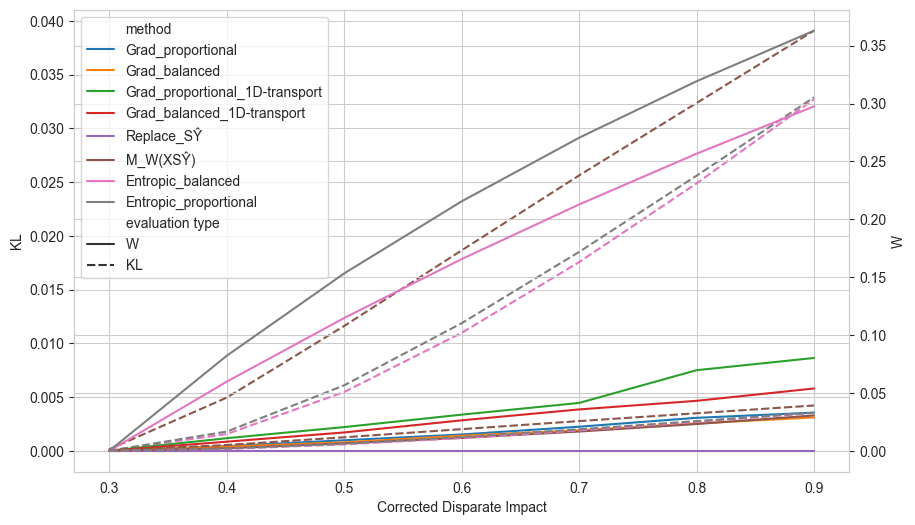

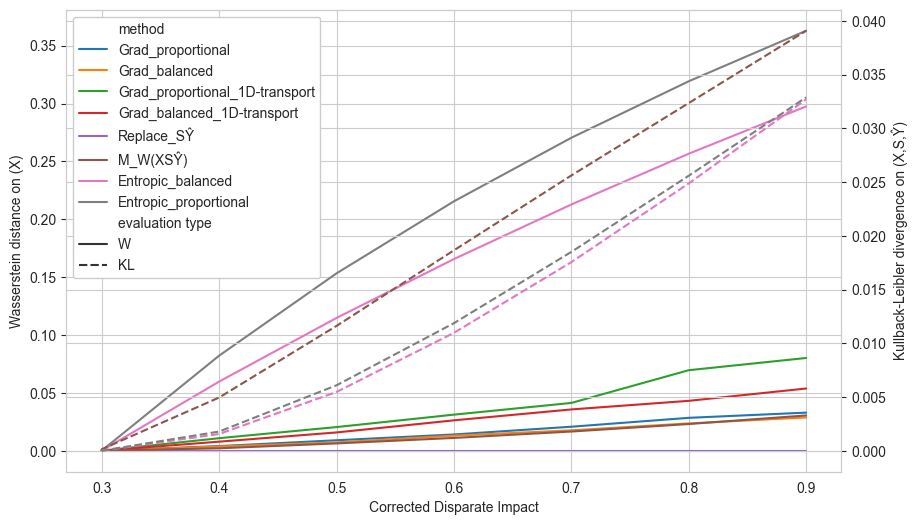

In [14]:
sns.set_style("whitegrid")
fig, ax1 = plt.subplots(figsize=(10, 6))

df['evaluation type'] =  'W'
df_KL_not_inf = df[df.KL != float('inf')]
list_DI, list_KL, list_method = df_KL_not_inf['DI'].values, df_KL_not_inf['KL'].values, df_KL_not_inf['method'].values
new_df = pd.DataFrame({'DI' : list_DI, 'W' : list_KL, 'KL' : list_KL, 'method' : list_method})
new_df['evaluation type'] = 'KL'
df_all = pd.concat([df, new_df])
sns.lineplot(data = df[df.KL != float('inf')], x = 'DI', y = 'KL', hue = 'method', ax=ax1, linestyle='--')
ax2 = ax1.twinx()
sns.lineplot(data = df_all, 
             x = 'DI', 
             y = 'W', 
             hue = 'method', 
             style = 'evaluation type',
             ax = ax2)
ax1.legend([],[], frameon=False)
ax1.set_xlabel('Corrected Disparate Impact')
handles, labels = ax2.get_legend_handles_labels()

sns.set_style("whitegrid")
fig, ax1 = plt.subplots(figsize=(10, 6))

df1 = df.copy()

sns.lineplot(data = df, x = 'DI', y = 'W', hue = 'method', ax=ax1, markers = 's')
ax2 = ax1.twinx()

sns.lineplot(data = df[df.KL != float('inf')], x = 'DI', y = 'KL', hue = 'method', ax=ax2, linestyle='--')
ax1.set_ylabel('Wasserstein distance on (X)')
ax2.set_ylabel('Kullback-Leibler divergence on (X,S,Ŷ)')
ax1.legend([],[], frameon=False)
ax2.legend([],[], frameon=False)
ax1.set_xlabel('Corrected Disparate Impact')

legend = ax2.legend(handles, labels, framealpha = 1)

plt.show()

## EMP

In [ ]:
df_emp = return_KL_W_result_unbaisedness_all_methods(folder = 'ASC_EMP', DI_end=0.90001)

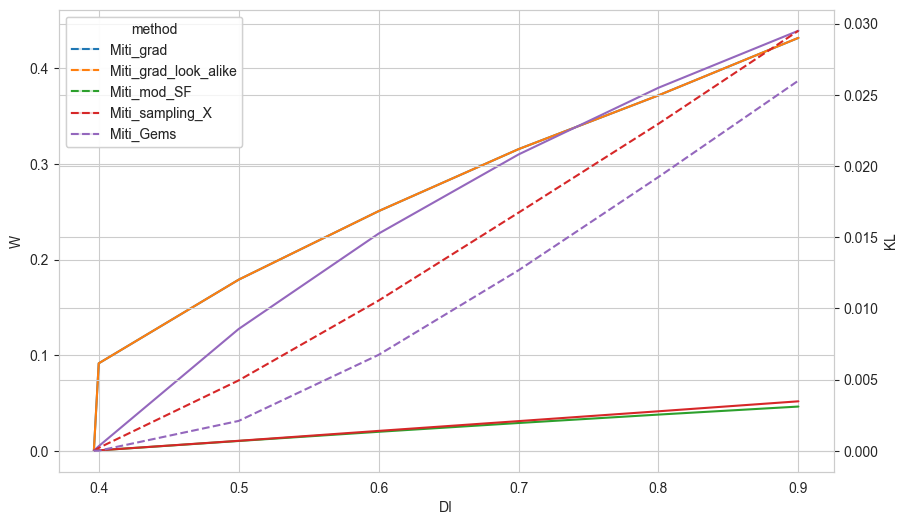

In [34]:
sns.set_style("whitegrid")
fig, ax1 = plt.subplots(figsize=(10, 6))

sns.lineplot(data = df_emp, x = 'DI', y = 'W', hue = 'method', ax=ax1, markers = 's')
ax2 = ax1.twinx()
sns.lineplot(data = df_emp[df_emp.KL != float('inf')], x = 'DI', y = 'KL', hue = 'method', ax=ax2, linestyle='--')
plt.show()

## INC

In [ ]:
df_inc = return_KL_W_result_unbaisedness_all_methods(folder = 'ASC_INC', DI_end=0.90001)

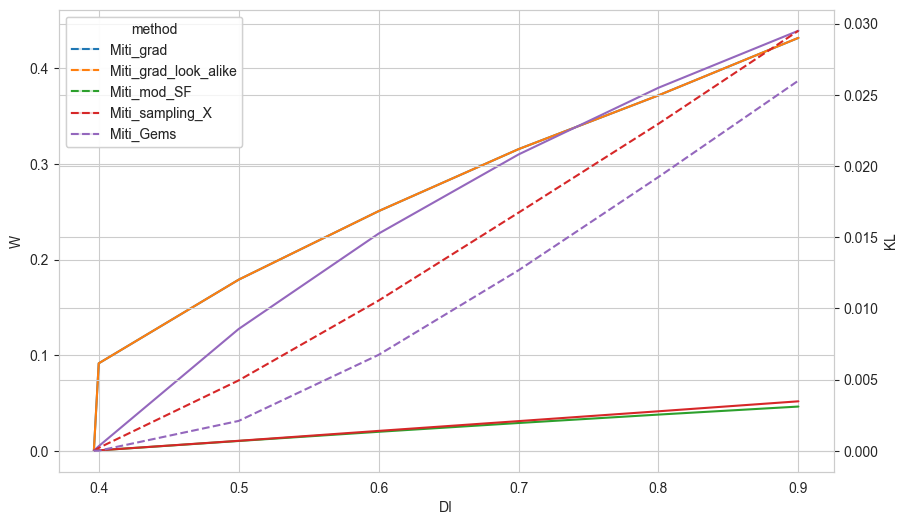

In [31]:
sns.set_style("whitegrid")
fig, ax1 = plt.subplots(figsize=(10, 6))

sns.lineplot(data = df_inc, x = 'DI', y = 'W', hue = 'method', ax=ax1, markers = 's')
ax2 = ax1.twinx()
sns.lineplot(data = df_inc[df_inc.KL != float('inf')], x = 'DI', y = 'KL', hue = 'method', ax=ax2, linestyle='--')
plt.show()

## BAF

In [ ]:
df_baf = return_KL_W_result_unbaisedness_all_methods(folder = 'BAF', DI_end=0.90001)

## MOB

In [6]:
df = return_KL_W_result_unbaisedness_all_methods(folder = 'ASC_MOB', 
                                                 DI_end = 0.90001,
                                                 verbose = True,
                                                 CONSTR_REGU = 1
                                                 )

  0%|          | 0/8 [00:00<?, ?it/s]

0.5
unbaisedness done
KL_A done : inf
W_A done : 0.009512294967591867
0.6
unbaisedness done
KL_A done : inf
W_A done : 0.02728296051889795
0.7
unbaisedness done
KL_A done : inf
W_A done : 0.04487971924093793
0.7999999999999999
unbaisedness done
KL_A done : inf
W_A done : 0.06240615800978546
0.8999999999999999
unbaisedness done
KL_A done : inf


 12%|█▎        | 1/8 [12:03<1:24:24, 723.43s/it]

W_A done : 0.07954606973515264
0.5
unbaisedness done
KL_A done : inf
W_A done : 0.005000016286021924
0.6
unbaisedness done
KL_A done : inf
W_A done : 0.014400016137908523
0.7
unbaisedness done
KL_A done : inf
W_A done : 0.02380001592082574
0.7999999999999999
unbaisedness done
KL_A done : inf
W_A done : 0.03320001571732249
0.8999999999999999
unbaisedness done
KL_A done : inf


 25%|██▌       | 2/8 [24:46<1:14:41, 746.99s/it]

W_A done : 0.04260001552284816
0.5
unbaisedness done
KL_A done : 0.0006625348523239655
W_A done : 0.027303341407211915
0.6
unbaisedness done
KL_A done : 0.005311178515483317
W_A done : 0.07809409846543139
0.7
unbaisedness done
KL_A done : 0.014079518060737943
W_A done : 0.12786059926815138
0.7999999999999999
unbaisedness done
KL_A done : 0.026810498161615112
W_A done : 0.17661451014688168
0.8999999999999999
unbaisedness done
KL_A done : 0.04364533614269068


 38%|███▊      | 3/8 [41:23<1:11:45, 861.18s/it]

W_A done : 0.22438130502271983
0.5
unbaisedness done
KL_A done : 0.007750823273532913
W_A done : 0.11489701366103013
0.6
unbaisedness done
KL_A done : 0.04790969922733033
W_A done : 0.3112171461389102
0.7
unbaisedness done
KL_A done : 0.10379400271121486
W_A done : 0.4844152331530014
0.7999999999999999
unbaisedness done
KL_A done : 0.16628037952791094
W_A done : 0.6383677586396111
0.8999999999999999
unbaisedness done
KL_A done : 0.2311036934254428


 50%|█████     | 4/8 [58:11<1:01:15, 918.98s/it]

W_A done : 0.7761147687126227
0.5
unbaisedness done
KL_A done : inf
W_A done : 0.03392806547863427
0.6
unbaisedness done
KL_A done : inf
W_A done : 0.09355987409570216
0.7
unbaisedness done
KL_A done : inf
W_A done : 0.14860642078406938
0.7999999999999999
unbaisedness done
KL_A done : inf
W_A done : 0.20595579372714196
0.8999999999999999
unbaisedness done
KL_A done : inf


 62%|██████▎   | 5/8 [5:56:43<5:52:19, 7046.62s/it]

W_A done : 0.2597805543135866
0.5
unbaisedness done
KL_A done : inf
W_A done : 0.03884014651710585
0.6
unbaisedness done
KL_A done : inf
W_A done : 0.10484718185958707
0.7
unbaisedness done
KL_A done : inf
W_A done : 0.17247039457743293
0.7999999999999999
unbaisedness done
KL_A done : inf
W_A done : 0.2340473703334974
0.8999999999999999
unbaisedness done
KL_A done : inf


 75%|███████▌  | 6/8 [22:20:10<13:43:46, 24713.35s/it]

W_A done : 0.30147249024121175
0.5
unbaisedness done
KL_A done : inf
W_A done : 0.010503483945634993
0.6
unbaisedness done
KL_A done : inf
W_A done : 0.03131125897652266
0.7
unbaisedness done
KL_A done : inf
W_A done : 0.05795212309766507
0.7999999999999999
unbaisedness done
KL_A done : inf
W_A done : 0.07974017129226343
0.8999999999999999
unbaisedness done
KL_A done : inf


 88%|████████▊ | 7/8 [28:30:11<6:38:11, 23891.96s/it] 

W_A done : 0.1033288651802092
0.5
unbaisedness done
KL_A done : 0.00210243196793291
W_A done : 0.005751992155264328
0.6
unbaisedness done
KL_A done : 0.007092639893024448
W_A done : 0.018474851701227243
0.7
unbaisedness done
KL_A done : 0.01253018566031138
W_A done : 0.0328394646200361
0.7999999999999999
unbaisedness done
KL_A done : 0.018267556962950026
W_A done : 0.04782117587977607
0.8999999999999999
unbaisedness done
KL_A done : 0.023218132045467067


100%|██████████| 8/8 [38:32:39<00:00, 17344.94s/it]  

W_A done : 0.06318135408523104


In [ ]:
df.to_csv('../Result/ASC_MOB/Unbiasedness.csv')

In [ ]:
df_MOB = pd.read_csv('../Result/ASC_MOB/Unbiasedness.csv')
df_MOB.head()

,Unnamed: 0,DI,KL,W,method
0,0,0.447046,0.0,0.000000,Grad_reg_num
1,1,0.500000,inf,0.009512,Grad_reg_num
2,2,0.600000,inf,0.027283,Grad_reg_num
3,3,0.700000,inf,0.044880,Grad_reg_num
4,4,0.800000,inf,0.062406,Grad_reg_num


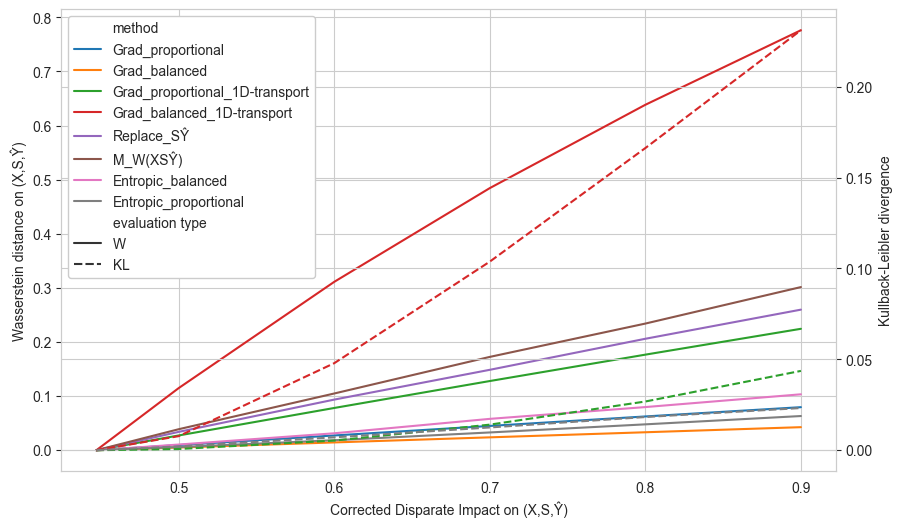

In [15]:
sns.set_style("whitegrid")
fig, ax1 = plt.subplots(figsize=(10, 6))

sns.lineplot(data = df_MOB, x = 'DI', y = 'W', hue = 'method', ax=ax1, markers = 's')
ax2 = ax1.twinx()

sns.lineplot(data = df_MOB[df_MOB.KL != float('inf')], x = 'DI', y = 'KL', hue = 'method', ax=ax2, linestyle='--')
ax1.set_ylabel('Wasserstein distance on (X,S,Ŷ)')
ax2.set_ylabel('Kullback-Leibler divergence')
ax1.legend([],[], frameon=False)
ax2.legend([],[], frameon=False)
ax1.set_xlabel('Corrected Disparate Impact on (X,S,Ŷ)')

legend = ax2.legend(handles, labels, framealpha = 1)

plt.show()

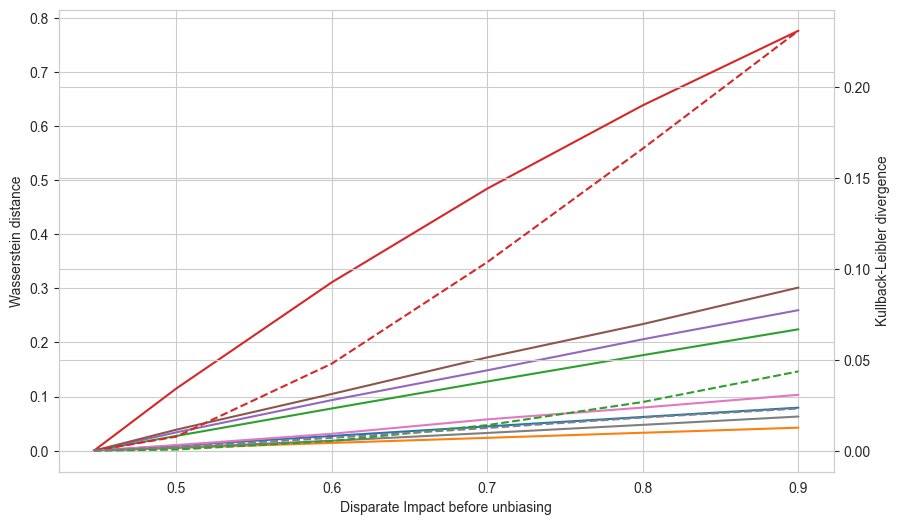

In [41]:
sns.set_style("whitegrid")
fig, ax1 = plt.subplots(figsize=(10, 6))
#df_MOB = df_MOB.rename(columns = {'DI' : 'Disparate Impact before unbiasing'})
sns.lineplot(data = df_MOB, x = 'Disparate Impact before unbiasing', y = 'W', hue = 'method', ax=ax1, markers = 's')
ax2 = ax1.twinx()
sns.lineplot(data = df_MOB[df_MOB.KL != float('inf')], x = 'Disparate Impact before unbiasing', y = 'KL', hue = 'method', ax=ax2, linestyle='--')
ax1.set_ylabel('Wasserstein distance')
ax2.set_ylabel('Kullback-Leibler divergence')
ax1.legend([],[], frameon=False)
ax2.legend([],[], frameon=False)
plt.show()

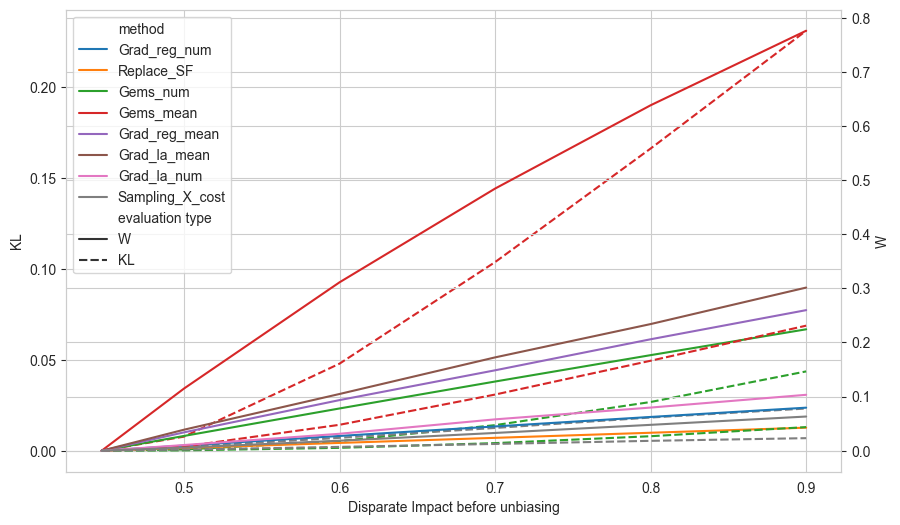

In [42]:
sns.set_style("whitegrid")
fig, ax1 = plt.subplots(figsize=(10, 6))

df_MOB['evaluation type'] =  'W'
df_KL_not_inf = df_MOB[df_MOB.KL != float('inf')]
list_DI, list_KL, list_method = df_KL_not_inf['Disparate Impact before unbiasing'].values, df_KL_not_inf['KL'].values, df_KL_not_inf['method'].values
new_df = pd.DataFrame({'Disparate Impact before unbiasing' : list_DI, 'W' : list_KL, 'KL' : list_KL, 'method' : list_method})
new_df['evaluation type'] = 'KL'
df_all = pd.concat([df_MOB, new_df])
sns.lineplot(data = df_MOB[df_MOB.KL != float('inf')], x = 'Disparate Impact before unbiasing', y = 'KL', hue = 'method', ax=ax1, linestyle='--')
ax2 = ax1.twinx()
sns.lineplot(data = df_all, 
             x = 'Disparate Impact before unbiasing', 
             y = 'W', 
             hue = 'method', 
             style = 'evaluation type',
             ax = ax2)
ax1.legend([],[], frameon=False)
plt.show()